In [1]:
!pip install nltk
!pip install tensorflow
!pip install -U spacy
!python -m spacy download en_core_web_sm

2022-06-08 22:05:21.872955: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 22:05:21.873007: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 12.8 MB 10.6 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import en_core_web_sm
nlp = en_core_web_sm.load()

import string
from string import digits

from spacy.lang.en.stop_words import STOP_WORDS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [3]:
train = pd.read_csv("SRC_projects/nlp_disaster/train.csv")
test = pd.read_csv("SRC_projects/nlp_disaster/test.csv")
sample_sub = pd.read_csv("SRC_projects/nlp_disaster/sample_submission.csv")

print("nombre de lignes pour le train set: ",train.shape[0])
display(train.head(2))
print("nombre de lignes pour le test set: ",test.shape[0])
display(test.head(2))

print("Pourcentage de valeurs manquantes sur le train set:")
print(train.isna().sum()*100 / train.shape[0])
print("Pourcentage de valeurs manquantes sur le test set:")
print(test.isna().sum()*100 / test.shape[0]) 
#On peut déja enlever la colonne location
#Je vais faire un dropna pour enlever les valeurs manquantes, la colonne keyword pourra m'être utile

nombre de lignes pour le train set:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


nombre de lignes pour le test set:  3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


Pourcentage de valeurs manquantes sur le train set:
id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64
Pourcentage de valeurs manquantes sur le test set:
id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64


<AxesSubplot:xlabel='target', ylabel='count'>

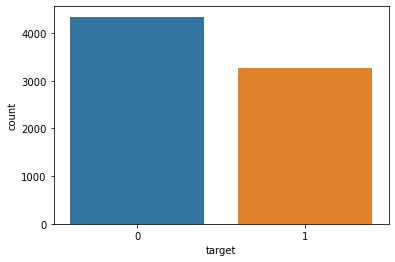

In [4]:
sns.countplot(x=train['target'])

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
table = str.maketrans('', '', digits)
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000)

In [7]:
def cleaning_encoding(df):
    
    df = df.drop('location', axis=1) # supprime la colonne location
    df = df.dropna() # j'enlève les lignes possédant des valeurs nulles
    df = df.reset_index() # je supprime l'index qui n'était pas ordonné suite au dropna
    df = df.drop('id',axis=1) # j'enlève la colonne id
    df = df.drop('index', axis=1) # et la colonne index
    
    df['text_clean'] = df['text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True) 
    #J'enlève les URLS

    df['text_clean'] = df['text_clean'].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
    #Je viens d'enlever toutes les caractères qui ne sont pas alphanumériques

    

    df['text_clean'] = df['text_clean'].apply(lambda x: x.translate(table)).apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower().strip())
    #str.maketrans('', '', digits) nous permet d'enlever les numbers
    #translate(str.maketrans('', '', string.punctuation)).lower() nous permet d'enlever la ponctuation et les majuscules 

    df['text_clean'] = df['text_clean'].apply(lambda x:" ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))
    #tokenization et lemmatization

    

    tokenizer.fit_on_texts(df.text_clean)
    df['text_encoded'] = tokenizer.texts_to_sequences(df.text_clean) #Nouvelle colonne, le texte est maintenant encodé

    df['len_text_encoded'] = df['text_encoded'].apply(lambda x: len(x))
    df = df[df['len_text_encoded']!=0] #nouvelle colonne avec la longueur de chaque liste de texte encodé
    
    return df

In [8]:
train_cleaned = cleaning_encoding(train)
test_cleaned = cleaning_encoding(test)

In [9]:
test_cleaned.head(10)

,keyword,text,text_clean,text_encoded,len_text_encoded
0,ablaze,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news ...,"[223, 428, 860, 8, 2, 75, 223]",7
1,ablaze,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear short race ablaze,"[994, 830, 428]",3
2,ablaze,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previouslyondoyintv toke makinwaûªs marriage c...,"[550, 128, 765, 388, 428]",5
3,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw,[199],1
4,ablaze,PSA: IÛªm splitting my personalities.\n\n?? t...,psa iûªm split personality techie follow ablaz...,"[275, 275, 428]",3
5,ablaze,beware world ablaze sierra leone &amp; guap.,beware world ablaze sierra leone amp guap,"[41, 428, 4]",3
6,ablaze,Burning Man Ablaze! by Turban Diva http://t.co...,burn man ablaze turban diva etsy,"[9, 27, 428]",3
7,ablaze,Not a diss song. People will take 1 thing and ...,diss song people thing run smh eye opener ...,"[348, 7, 100, 76, 979, 246, 128, 178, 428]",9
8,ablaze,Rape victim dies as she sets herself ablaze: A...,rape victim die set ablaze yearold girl die bu...,"[419, 84, 128, 428, 497, 185, 84, 9, 78, 128]",10
9,ablaze,SETTING MYSELF ABLAZE http://t.co/6vMe7P5XhC,set ablaze,"[128, 428]",2


In [10]:
display(train_cleaned.head())
print(train.shape[0], "rows")

,keyword,text,target,text_clean,text_encoded,len_text_encoded
0,ablaze,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,bbcmtd wholesale market ablaze,"[259, 434]",2
1,ablaze,We always try to bring the heavy. #metal #RT h...,0,try bring heavy metal rt,"[127, 260, 657, 933, 46]",5
2,ablaze,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africanbaze break newsnigeria flag set ablaze aba,"[85, 498, 128, 434, 876]",5
3,ablaze,Crying out for more! Set me ablaze,0,cry set ablaze,"[620, 128, 434]",3
4,ablaze,On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,plus look sky night ablaze,"[21, 692, 176, 434]",4


7613 rows


In [11]:
display(test_cleaned.head())
print(test.shape[0], "rows")

,keyword,text,text_clean,text_encoded,len_text_encoded
0,ablaze,Birmingham Wholesale Market is ablaze BBC News...,birmingham wholesale market ablaze bbc news ...,"[223, 428, 860, 8, 2, 75, 223]",7
1,ablaze,@sunkxssedharry will you wear shorts for race ...,sunkxssedharry wear short race ablaze,"[994, 830, 428]",3
2,ablaze,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,previouslyondoyintv toke makinwaûªs marriage c...,"[550, 128, 765, 388, 428]",5
3,ablaze,Check these out: http://t.co/rOI2NSmEJJ http:/...,check nsfw,[199],1
4,ablaze,PSA: IÛªm splitting my personalities.\n\n?? t...,psa iûªm split personality techie follow ablaz...,"[275, 275, 428]",3


3263 rows


In [12]:
train_pad = tf.keras.preprocessing.sequence.pad_sequences(train_cleaned.text_encoded, padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(test_cleaned.text_encoded, padding="post", maxlen=train_pad.shape[1])

In [13]:
full_train_ds = tf.data.Dataset.from_tensor_slices((train_pad, train_cleaned.target.values))
full_test_ds = tf.data.Dataset.from_tensor_slices((test_pad))

In [14]:
# Train test split
TAKE_SIZE = int(0.7*train_cleaned.shape[0])

train_cleaned_data = full_train_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_cleaned_data = train_cleaned_data.batch(64)

val_data = full_train_ds.skip(TAKE_SIZE)
val_data = val_data.batch(64)

test_data = full_test_ds.batch(64)

In [15]:
for tweet, target in train_cleaned_data.take(1):
    print(tweet, target)

tf.Tensor(
[[128 261 434 ...   0   0   0]
 [736 607   0 ...   0   0   0]
 [  6 359 353 ...   0   0   0]
 ...
 [ 35 539 613 ...   0   0   0]
 [ 24 266 733 ...   0   0   0]
 [ 39  56 371 ...   0   0   0]], shape=(64, 17), dtype=int32) tf.Tensor(
[0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0], shape=(64,), dtype=int64)


In [16]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM, Dropout

In [17]:
vocab_size = len(tokenizer.word_index)
model_lstm = tf.keras.Sequential([
            Embedding(vocab_size+1, 8, input_shape=[tweet.shape[1],], name='embedding'),
            LSTM(units=32, return_sequences=True),
            Dropout(rate=0.2),
            LSTM(units=16, return_sequences=False),
            Dense(8, activation='relu'),

            Dense(1, activation="sigmoid", name="last")])

In [18]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 8)             151984    
                                                                 
 lstm (LSTM)                 (None, 17, 32)            5248      
                                                                 
 dropout (Dropout)           (None, 17, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 last (Dense)                (None, 1)                 9         
                                                                 
Total params: 160,513
Trainable params: 160,513
Non-trai

In [19]:
optimizer = tf.keras.optimizers.Adam()

model_lstm.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy()])

In [20]:
history = model_lstm.fit(train_cleaned_data,
              epochs=5,
              validation_data=val_data)

Epoch 1/10
82/82 [==============================] - 8s 41ms/step - loss: 0.6488 - binary_accuracy: 0.6163 - val_loss: 0.6362 - val_binary_accuracy: 0.7354
Epoch 2/10
82/82 [==============================] - 2s 29ms/step - loss: 0.5048 - binary_accuracy: 0.7955 - val_loss: 0.5403 - val_binary_accuracy: 0.7416
Epoch 3/10
82/82 [==============================] - 2s 28ms/step - loss: 0.4266 - binary_accuracy: 0.8167 - val_loss: 0.5328 - val_binary_accuracy: 0.7461
Epoch 4/10
82/82 [==============================] - 2s 29ms/step - loss: 0.3923 - binary_accuracy: 0.8369 - val_loss: 0.5886 - val_binary_accuracy: 0.7305
Epoch 5/10
82/82 [==============================] - 2s 28ms/step - loss: 0.3780 - binary_accuracy: 0.8457 - val_loss: 0.5806 - val_binary_accuracy: 0.7176
Epoch 6/10
82/82 [==============================] - 2s 27ms/step - loss: 0.3670 - binary_accuracy: 0.8524 - val_loss: 0.5779 - val_binary_accuracy: 0.7114
Epoch 7/10
82/82 [==============================] - 2s 28ms/step - los

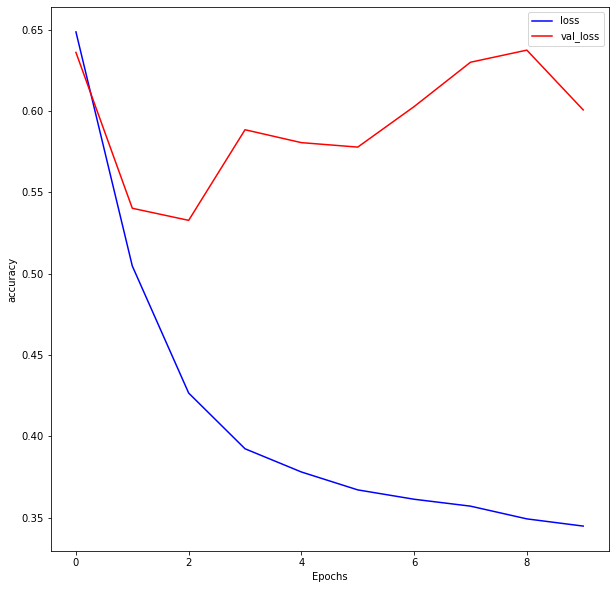

In [21]:
# Visualization of accuracy training 
plt.figure(figsize=(10,10))
plt.plot(history.history["loss"], color="b", label="loss")
plt.plot(history.history["val_loss"], color="r", label="val_loss")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [22]:
sample_sub #ce dataset correspond à la colonne target du dataset test

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [23]:
predictions = model_lstm.predict(test_data)

51/51 [==============================] - 1s 8ms/step


In [32]:
predictions.reshape(1, -1)

array([[0.8491251 , 0.7807853 , 0.31165266, ..., 0.2359073 , 0.9001261 ,
        0.17261449]], dtype=float32)

In [36]:
predictions = pd.DataFrame(predictions, columns=["Predictions"])

In [38]:
predictions["Predictions"] = predictions["Predictions"].apply(lambda x: 0 if x<0.5 else 1)

In [39]:
predictions

,Predictions
0,1
1,1
2,0
3,0
4,1
...,...
3199,1
3200,1
3201,0
3202,1
